In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
from pandas import datetime 

import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from fbprophet import Prophet

In [2]:
train = pd.read_csv('./input/train.csv', parse_dates=True, low_memory=False, index_col='Date')

store = pd.read_csv('./input/store.csv', low_memory=False)

train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [3]:
print('In Total: ', train.shape)
train.head()

In Total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [4]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

train['SalePerCustomer'] = train['Sales'] / train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

Text(0.5, 0, 'Sale per Customer')

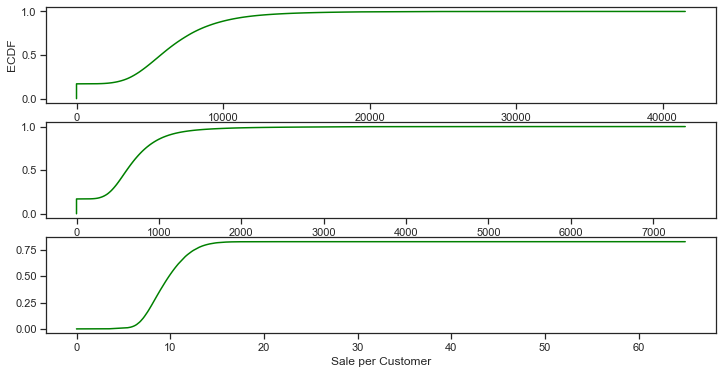

In [5]:
sns.set(style='ticks')
c = 'green'
plt.figure(figsize=(12,6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label='statmodels', color=c)
plt.xlabel('Sales'); plt.ylabel('ECDF')

plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label='statmodels', color=c)
plt.xlabel('Customers')

plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label='statmodels', color=c)
plt.xlabel('Sale per Customer')

In [6]:
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [7]:
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print('In Total: ', zero_sales.shape)
zero_sales.head()

In Total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [8]:
print('Closed Stores')
train = train[(train['Open'] != 0) & (train['Sales'] != 0)]
print('In Total: ', train.shape)

Closed Stores
In Total:  (844338, 13)


In [9]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [11]:
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [12]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [13]:
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

In [14]:
store.fillna(0, inplace=True)

In [15]:
train_store = pd.merge(train, store, how='inner', on='Store')
print('In Total: ', train_store.shape)
train_store.head()

In Total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [16]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [17]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


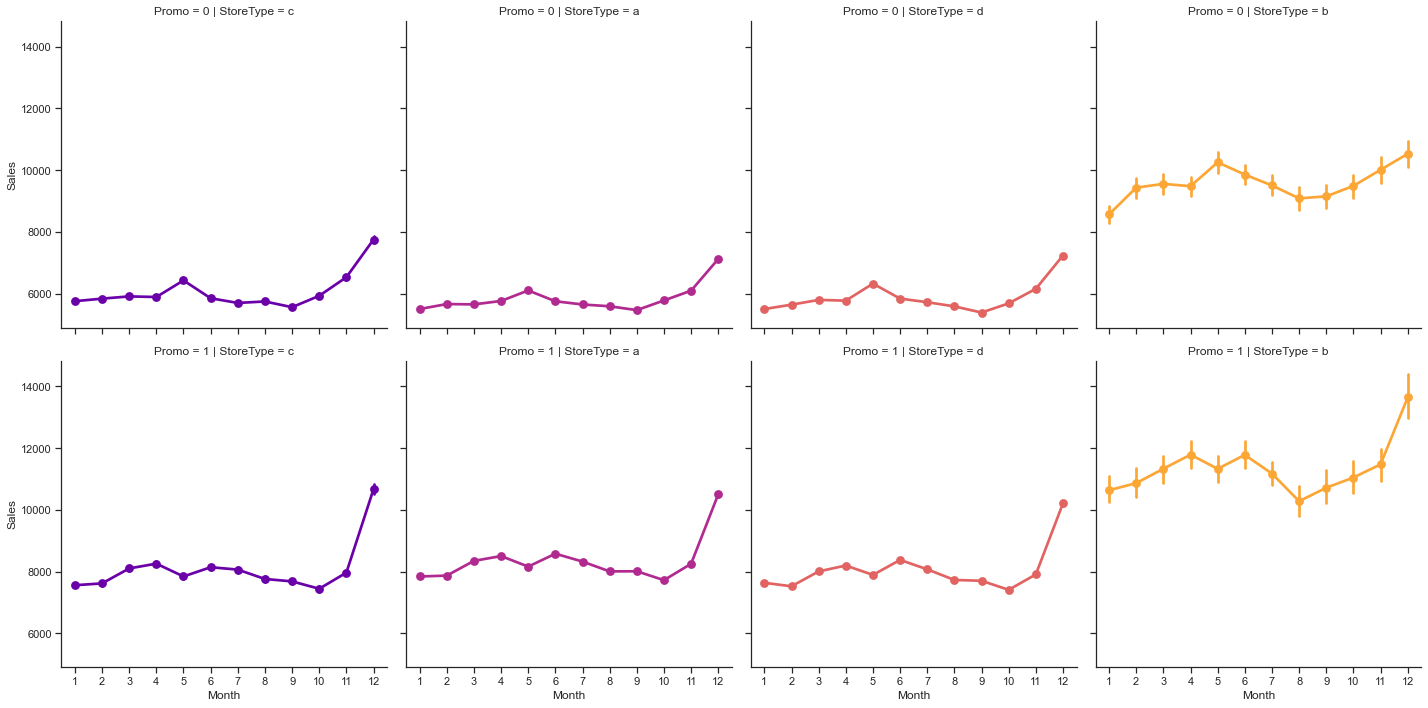

In [18]:
sns.factorplot(data = train_store, x='Month', y='Sales',
               col = 'StoreType', palette='plasma', hue='StoreType',
               row='Promo', color=c)

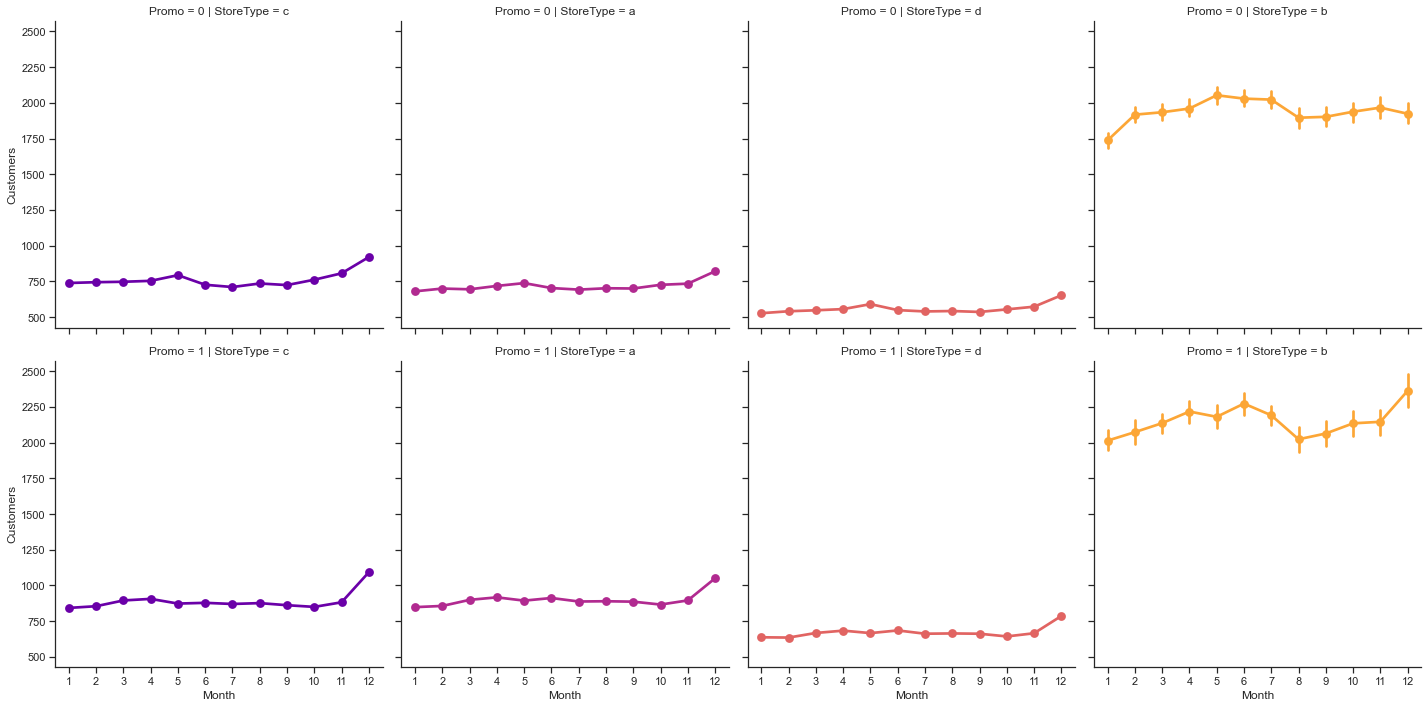

In [19]:
sns.factorplot(data=train_store, x='Month', y='Customers', 
               col = 'StoreType', palette='plasma', hue='StoreType', 
               row='Promo', color=c)

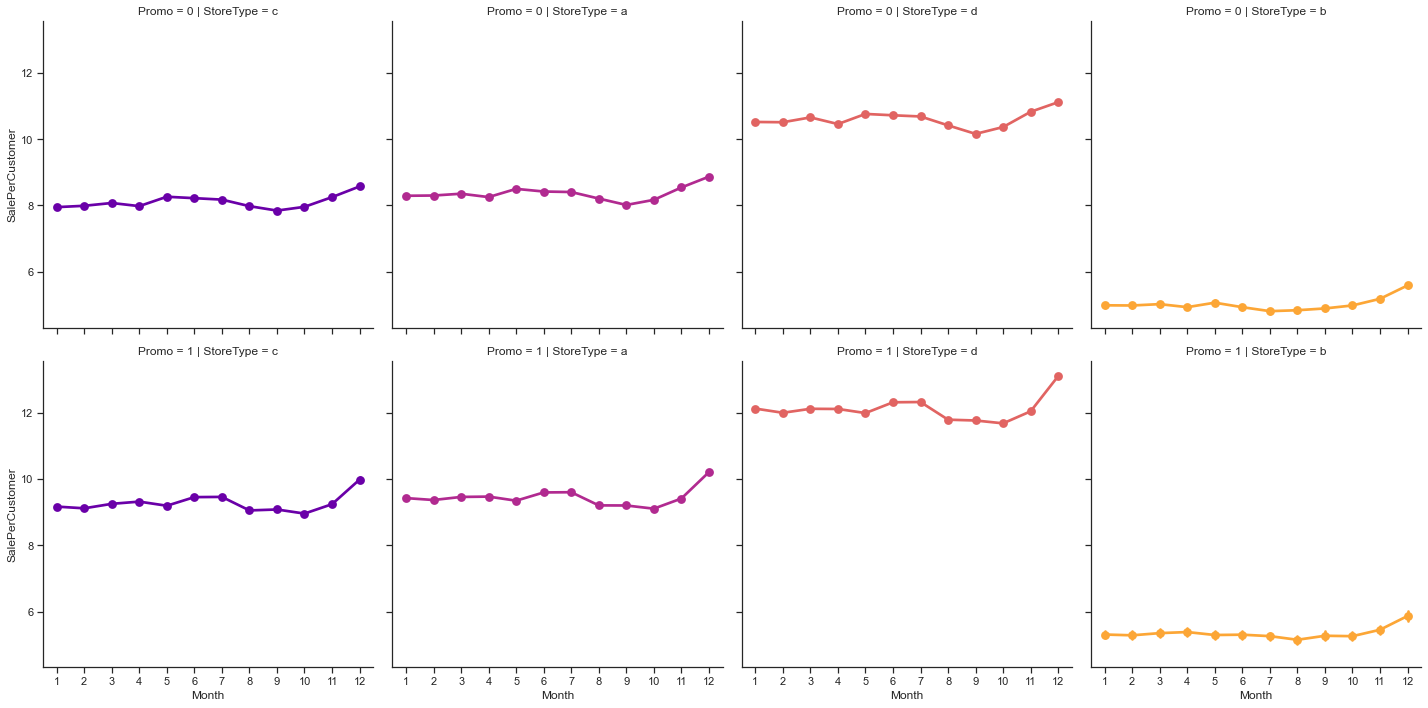

In [20]:
sns.factorplot(data = train_store, x='Month', y="SalePerCustomer", 
               col='StoreType', palette='plasma', hue='StoreType',
               row='Promo', color=c) 

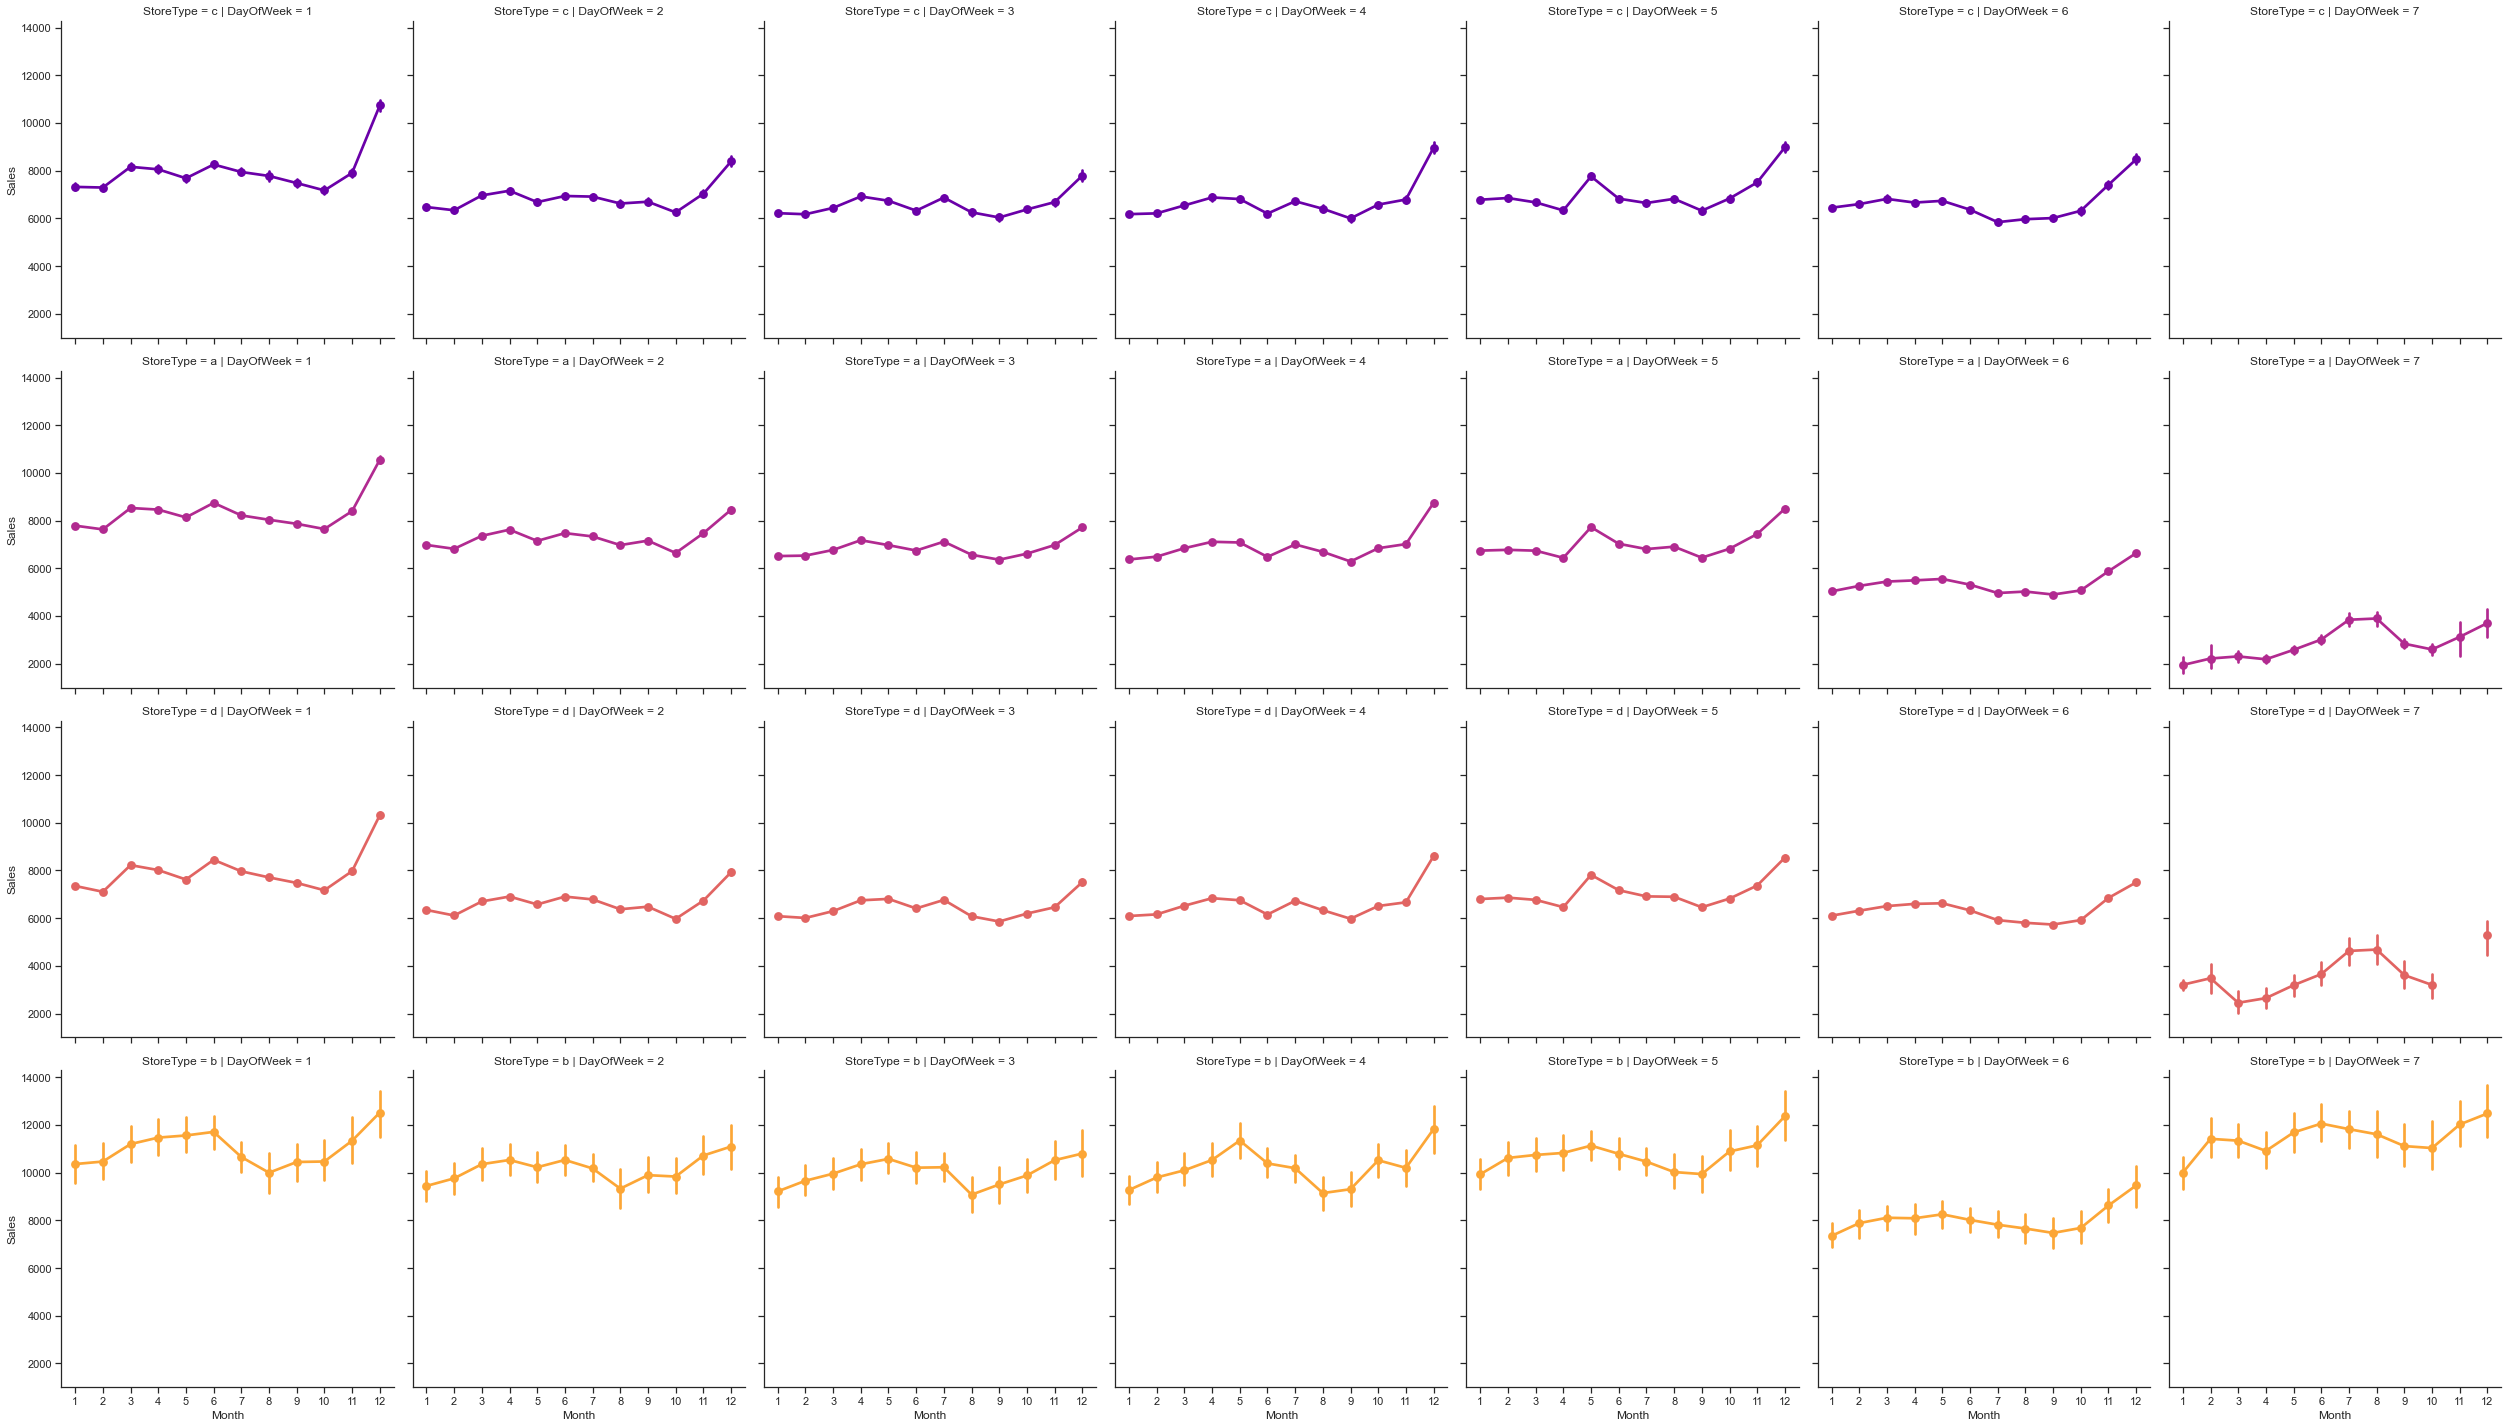

In [21]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', palette = 'plasma', hue = 'StoreType',
               row = 'StoreType', color = c) 

In [22]:
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

In [23]:
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    

train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0


train_store.fillna(0, inplace = True)


train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


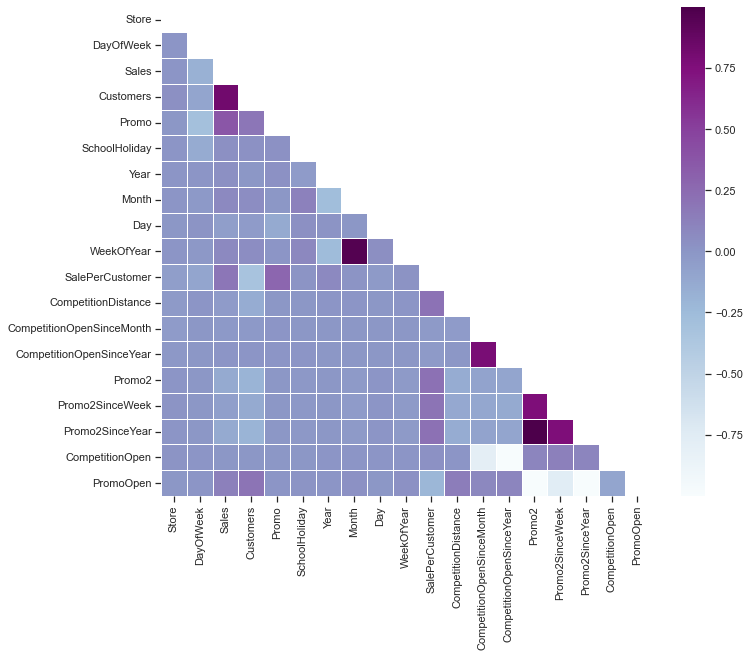

In [24]:
corr_all = train_store.drop('Open', axis=1).corr()

mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11,9))

sns.heatmap(corr_all, mask=mask, square=True, linewidths=.5, ax=ax, cmap='BuPu')
plt.show()

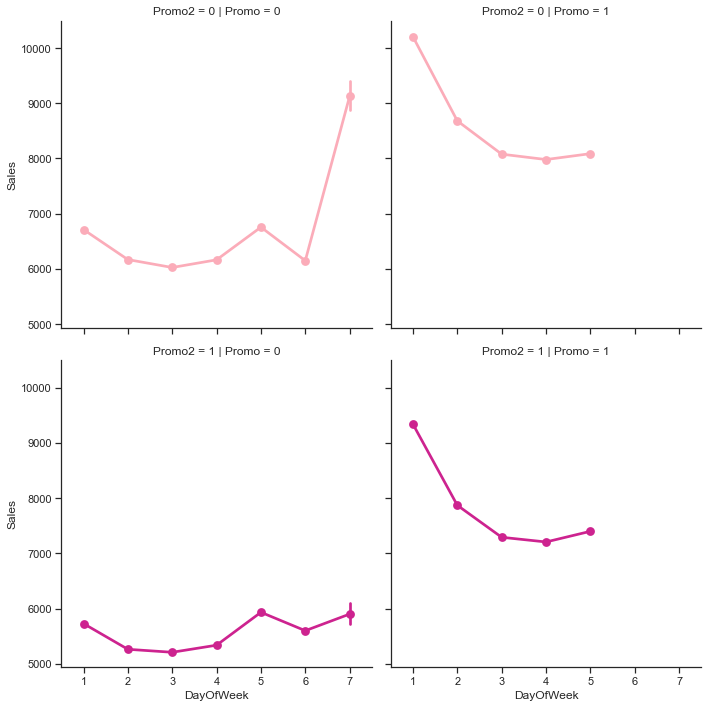

In [25]:
sns.factorplot(data=train_store, x='DayOfWeek', y='Sales', 
               col='Promo', row='Promo2', hue='Promo2', palette='RdPu')

<AxesSubplot:xlabel='Date'>

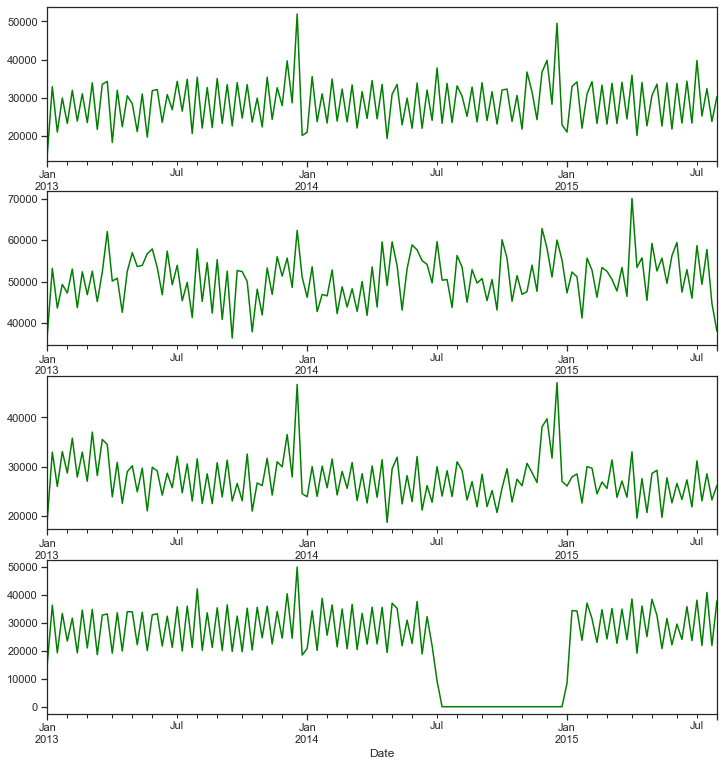

In [26]:
train['Sales'] = train['Sales'] * 1.0


sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))


sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

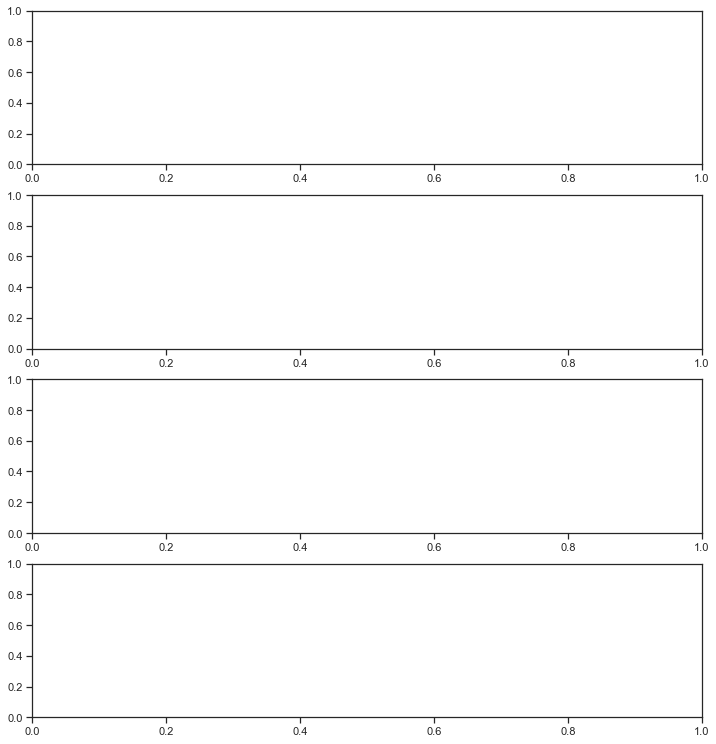

In [28]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))


decomposition_a = seasonal_decompose(sales_a, model = 'additive')
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive')
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive')
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive')
decomposition_d.trend.plot(color = c, ax = ax4)